In [ ]:
pip install --upgrade scikit-learn==1.0.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 55.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

!pip install scikit-tensor-py3==0.2.1
from sktensor import dtensor

import pandas as pd
import numpy as np

import time
import datetime
import copy
import os
import joblib
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 869.9 kB/s eta 0:00:00


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device('cuda')

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('Use GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Use GPU: Tesla T4


# 2. Helper Functions

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 3. Load Data

In [ ]:
# Read data

%%time

file_path_train = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/TrainData_adjusted.csv'
file_path_test = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/TestData_adjusted.csv'

cols = ['userId', 'gender', 'sport', 'calories',
        'route_id', 'distance', 'distance_adjusted_sum']

train_df = pd.read_csv(file_path_train, usecols=cols)
test_df = pd.read_csv(file_path_test, usecols=cols)

train_df.rename(columns={'distance': 'workout_distance',
                         'distance_adjusted_sum': 'total_distance'},
                inplace=True)

test_df.rename(columns={'distance': 'workout_distance',
                        'distance_adjusted_sum': 'total_distance'},
               inplace=True)

print(train_df.shape)
print(test_df.shape)

display(train_df.head(1))

(53053, 7)
(13264, 7)


,userId,gender,sport,calories,workout_distance,route_id,total_distance
0,2060912,male,run,266.0,3.26,1,3.26


CPU times: user 26.3 s, sys: 3.46 s, total: 29.8 s
Wall time: 1min 10s


# 4. Data Processing

In [ ]:
# Encode gender feature

conditions = [
    (train_df['gender'] == 'male'),
    (train_df['gender'] == 'female'),
    (train_df['gender'] == 'unknown')]

choices = [0, 1, 2]

train_df['genderId'] = np.select(conditions, choices, default=0)

conditions = [
    (test_df['gender'] == 'male'),
    (test_df['gender'] == 'female'),
    (test_df['gender'] == 'unknown')]

test_df['genderId'] = np.select(conditions, choices, default=0)

In [ ]:
# Encode sport feature

conditions = [
    (train_df['sport'] == 'run'),
    (train_df['sport'] == 'bike'),
    (train_df['sport'] == 'mountain bike')]

choices = [0, 1, 2]

train_df['sportId'] = np.select(conditions, choices, default=0)

conditions = [
    (test_df['sport'] == 'run'),
    (test_df['sport'] == 'bike'),
    (test_df['sport'] == 'mountain bike')]

test_df['sportId'] = np.select(conditions, choices, default=0)

In [ ]:
# Load Min-max scaler models

scaler_dic = dict()
features = ['calories', 'distance']

dir = '/content/drive/MyDrive/P3 Fitrec Dataset/scaler'

for feature in features:
    path = os.path.join(dir, 'scaler_'+feature+'_2.m')
    scaler_dic[feature] = joblib.load(path)
    scaler_dic[feature].clip = False


scaler_dic['workout_distance'] = scaler_dic['distance']
scaler_dic['total_distance'] = scaler_dic['distance']
del scaler_dic['distance']

scaler_dic

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


{'calories': MinMaxScaler(),
 'workout_distance': MinMaxScaler(),
 'total_distance': MinMaxScaler()}

In [ ]:
# Apply min max scaler for selected features

%%time


# for features in context_df
for feature in train_df[['calories', 'workout_distance', 'total_distance']].columns:
    # Reshape data using array.reshape(-1, 1) if data has a single feature=4w
    train_df[feature] = scaler_dic[feature].transform(
        train_df[feature].to_numpy().reshape(-1, 1))

    test_df[feature] = scaler_dic[feature].transform(
        test_df[feature].to_numpy().reshape(-1, 1))


display(train_df.head(1))

,userId,gender,sport,calories,workout_distance,route_id,total_distance,genderId,sportId
0,2060912,male,run,0.047764,0.024867,1,0.024867,0,0


CPU times: user 17.7 ms, sys: 0 ns, total: 17.7 ms
Wall time: 20.8 ms


In [ ]:
# # Fit onehot encoder for categorical features

# OneHot_enc = OneHotEncoder()
# OneHot_enc.fit(pd.concat([train_df[['genderId', 'sportId']],
#                           test_df[['genderId', 'sportId']]]))

# # Save onehot encoder

# file_path = '/content/drive/My Drive/Colab Notebooks/DATA5703/OneHotEncoder.m'

# joblib.dump(OneHot_enc, file_path)

# Load onehot encoder for categorical features

dir = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/OneHotEncoder.m'

OneHot_enc = joblib.load(dir)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.22.2.post1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# Load user embedding and route embedding
# Note that we try different entity embedding sizes in our experiments in section 7


# # Entity Embedding size 3
#user_dir = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/user_embedding_3.m'
#route_dir = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/route_embedding_3.m'

# # Entity Embedding size 4
#user_dir = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/user_embedding_4.m'
#route_dir = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/route_embedding_4.m'

# # Entity Embedding size 9
#user_dir = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/user_embedding_9.m'
#route_dir = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/route_embedding_9.m'

# Entity Embedding size 17
user_dir = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/user_embedding_17.m'
route_dir = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/EMBEDDINGS/route_embedding_17.m'

user_embed_df = joblib.load(user_dir)
route_embed_df = joblib.load(route_dir)

In [ ]:
# find user embedding and route embedding for each row of data

%%time

# train data
train_userId_arr = train_df.userId.to_numpy()
train_userEmbed_arr = np.array([np.array(
    user_embed_df[user_embed_df.userId == userId].userEmbed.values[0]) for userId in train_userId_arr])

train_Route_id_arr = train_df.route_id.to_numpy()
train_routeEmbed_arr = np.array([np.array(
    route_embed_df[route_embed_df.route_id == route_id].routeEmbed.values[0]) for route_id in train_Route_id_arr])

# test data
test_userId_arr = test_df.userId.to_numpy()
test_userEmbed_arr = np.array([np.array(
    user_embed_df[user_embed_df.userId == userId].userEmbed.values[0]) for userId in test_userId_arr])

test_Route_id_arr = test_df.route_id.to_numpy()
test_routeEmbed_arr = np.array([np.array(
    route_embed_df[route_embed_df.route_id == route_id].routeEmbed.values[0]) for route_id in test_Route_id_arr])

CPU times: user 52.4 s, sys: 1.73 s, total: 54.1 s
Wall time: 55.8 s


In [ ]:
# one hot encode gender and sport features

%%time

# train data
train_gender_sport_arr = train_df[['genderId', 'sportId']].to_numpy()
train_gender_sport_arr = OneHot_enc.transform(train_gender_sport_arr).toarray()

# test data
test_gender_sport_arr = test_df[['genderId', 'sportId']].to_numpy()
test_gender_sport_arr = OneHot_enc.transform(test_gender_sport_arr).toarray()

CPU times: user 12.8 ms, sys: 2.92 ms, total: 15.7 ms
Wall time: 25.4 ms


In [ ]:
# train_data_arr: calories (1), total_distance (1), user embedding (3/4/9), route embedding (3/4/9), gender onehot (3), sport onehot (3)

%%time

# train data
train_data_arr = np.hstack((train_df[['calories', 'total_distance']].to_numpy(
), train_userEmbed_arr, train_routeEmbed_arr, train_gender_sport_arr))
train_label_arr = train_df.workout_distance.to_numpy()

# test data
test_data_arr = np.hstack((test_df[['calories', 'total_distance']].to_numpy(
), test_userEmbed_arr, test_routeEmbed_arr, test_gender_sport_arr))
test_label_arr = test_df.workout_distance.to_numpy()

print('train_data_arr shape: ', train_data_arr.shape)
print('train_label_arr shape: ', train_label_arr.shape)
print('test_data_arr shape: ', test_data_arr.shape)
print('test_label_arr shape: ', test_label_arr.shape)

train_data_arr shape:  (53053, 42)
train_label_arr shape:  (53053,)
test_data_arr shape:  (13264, 42)
test_label_arr shape:  (13264,)
CPU times: user 12.7 ms, sys: 7.9 ms, total: 20.6 ms
Wall time: 22.1 ms


In [ ]:
# train validation split

train_data, val_data, train_label, val_label = train_test_split(
    train_data_arr, train_label_arr, test_size=0.2, shuffle=True, random_state=1021)

print('train data count: ', train_data.shape[0])
print('val data count: ', val_data.shape[0])
print('test data count: ', test_data_arr.shape[0])

train data count:  42442
val data count:  10611
test data count:  13264


# 5. Build Dataset and DataLoader

In [ ]:
class DisReg_Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

	# return a data sample
    def __getitem__(self, idx):

        data = self.X[idx]
        label = self.y[idx]

        return data, label

    def __len__(self):
        return len(self.X)

In [ ]:
ds_train = DisReg_Data(train_data, train_label)
dl_train = torch.utils.data.DataLoader(ds_train,
                                       batch_size=32,
                                       shuffle=True,
                                       drop_last=True)

ds_val = DisReg_Data(val_data, val_label)
dl_val = torch.utils.data.DataLoader(ds_val,
                                     batch_size=32,
                                     shuffle=True,
                                     drop_last=True)

ds_test = DisReg_Data(test_data_arr, test_label_arr)
dl_test = torch.utils.data.DataLoader(ds_test,
                                     batch_size=32,
                                     shuffle=True,
                                     drop_last=True)

# 6. Define functions to save model, load model, train model

In [ ]:
def save_model(filename,
               best_model,
               best_epoch,
               best_loss_train,
               lowest_loss_val,
               epochs,
               latest_model,
               optimiser,
               total_losses_train,
               total_losses_val):

    DATA_PATH = "/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/"+filename
    state = {
        'best_model_state_dict': best_model,
        'best_epoch': best_epoch,
        'best_loss_train': best_loss_train,
        'lowest_loss_val': lowest_loss_val,
        'epochs': epochs,
        'latest_model_state_dict': latest_model,
        'optimiser_state_dict': optimiser,
        'total_losses_train': total_losses_train,
        'total_losses_val': total_losses_val
    }
    torch.save(state, DATA_PATH)


def train_model(model,
                optimiser,
                criterion,
                num_epochs,
                dl_train,
                dl_val,
                show_progress_epoch,
                save_model_epoch,
                save_model_name,
                continue_train = False,
                previous_best_train_loss = 0,
                previous_lowest_val_loss = 0,
                best_model_state_dict = 0,
                previous_best_epoch = 0,
                previous_epochs = 0,
                previous_train_loss = 0,
                previous_val_loss = 0):

    checkpoint = time.time()

    # we have this parameter passed to the function to indicate if we continue training
    if continue_train:
        # if continue training, we load previous training progress
        epochs = previous_epochs
        total_losses_train = previous_train_loss
        total_losses_val = previous_val_loss
        num_epoch_from_previous_training = previous_epochs[-1]+1
        best_epoch = previous_best_epoch
        best_loss_train = previous_best_train_loss
        lowest_loss_val = previous_lowest_val_loss
        best_model_wts = copy.deepcopy(best_model_state_dict)

    else:
        # if not continue training, we create new variables to save training progress
        epochs = []
        total_losses_train = []
        total_losses_val = []
        num_epoch_from_previous_training = 1
        lowest_loss_val = 100000.


    # iterate over number of epochs

    for epoch in range(num_epoch_from_previous_training, num_epochs+1):

        check_epoch = time.time()

        # update epoch record
        epochs.append(epoch)

        # Training:
        # create empty list to save training loss for each epoch
        train_losses_epoch = []

        # iterate over mini-batches

        for train_data, train_label in dl_train:

            # convert to cuda if available
            train_data = train_data.float().to(device)
            train_label = train_label.float().to(device)


            # model prediction and back propagation
            model.train()

            optimiser.zero_grad()
            output = model(train_data)
            loss = criterion(output.squeeze(), train_label)

            loss.backward()
            optimiser.step()

            # store mini-batch loss
            train_losses_epoch.append(loss.item())

        # get average training loss for the epoch over mini-batches
        train_losses_epoch = np.average(train_losses_epoch)

        # add training loss of epoch to total training loss list
        total_losses_train.append(train_losses_epoch)

        # Validation:

        # create empty list to save val loss for each epoch
        val_losses_epoch = []

        for val_data, val_label in dl_val:

            # convert to cuda if available
            val_data = val_data.float().to(device)
            val_label = val_label.float().to(device)

            model.eval()

            with torch.no_grad():
                output = model(val_data)
                loss = criterion(output.squeeze(), val_label)

            val_losses_epoch.append(loss.item())

        # get average val loss for the epoch over mini-batches
        val_losses_epoch = np.average(val_losses_epoch)
        # add val loss of epoch to total val loss list
        total_losses_val.append(val_losses_epoch)

        elapsed_epoch = format_time(time.time() - check_epoch)

        # show training progress at pre-defined interval
        if epoch % show_progress_epoch == 0:
            print('Epoch: {} Elapsed {} | Train Loss: {:.4} | Val Loss: {:.4}'.format(
                epoch, elapsed_epoch, train_losses_epoch, val_losses_epoch))

        # save best model
        if val_losses_epoch < lowest_loss_val:
            lowest_loss_val = val_losses_epoch
            best_epoch = epoch
            best_loss_train = train_losses_epoch
            best_model = copy.deepcopy(model)


        # save model during training at pre-defined interval
        if epoch % save_model_epoch == 0:
            save_model(save_model_name,
                       best_model.state_dict(),
                       best_epoch,
                       best_loss_train,
                       lowest_loss_val,
                       epochs,
                       model.state_dict(),
                       optimiser.state_dict(),
                       total_losses_train,
                       total_losses_val)


    elapsed = format_time(time.time() - checkpoint)
    print('Training complete in: {}. Lowest validation loss occurred at epoch {}: {:.4}'.format(
                elapsed, best_epoch, lowest_loss_val))

In [ ]:
# Define function to load model

def load_model(filename, best_model, latest_model):

    DATA_PATH = "/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/"+filename

    checkpoint = torch.load(DATA_PATH)

    best_model.load_state_dict(checkpoint['best_model_state_dict'])
    best_epoch = checkpoint['best_epoch']
    best_loss_train = checkpoint['best_loss_train']
    lowest_loss_val = checkpoint['lowest_loss_val']
    epochs = checkpoint['epochs']
    latest_model.load_state_dict(checkpoint['latest_model_state_dict'])
    optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
    total_losses_train = checkpoint['total_losses_train']
    total_losses_val = checkpoint['total_losses_val']

    return best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, \
        latest_model, optimiser, total_losses_train, total_losses_val

# 7. Experiments

## 7.1 Hyperparameter exploration with basic 2-layer MLP model with entity embedding size of 3

**Ensure entity embeddings with size 3 were loaded in Data Processing**

### 7.1.1 Define Model

In [ ]:
# Define model

class DisReg_MLP_2Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, p):
        super(DisReg_MLP_2Layer, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, 1)

        self.act_1 = nn.ReLU()
        self.act_2 = nn.Sigmoid()

        self.drop_1 = nn.Dropout(p)

    def forward(self, data):
        output = self.fc1(data)
        output = self.act_1(output)
        output = self.drop_1(output)

        output = self.fc2(output)
        output = self.act_2(output)

        return output

### 7.1.2 Random Search

In [ ]:
# Fixed parameters

INPUT_DIM = 14 # when entity embedding size = 3
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1

In [ ]:
# Random Search

np.random.seed(32)

LEARNING_RATE = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
HIDDEN_DIM = np.array([4, 8, 16, 32, 64])
WEIGHT_DECAY = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
DROP_OUT = np.array([0., 0.1, 0.2, 0.3, 0.4, 0.5])

para_result = []

N_TRIAL = 30

for trial in range(1, N_TRIAL+1):
    lr = np.random.choice(LEARNING_RATE)
    hd = np.random.choice(HIDDEN_DIM)
    wd = np.random.choice(WEIGHT_DECAY)
    dp = np.random.choice(DROP_OUT)

    DisReg_MLP_tmp = DisReg_MLP_2Layer(
        INPUT_DIM, hd, dp).to(device)

    optimiser = optim.Adam(
        DisReg_MLP_tmp.parameters(),
        lr=lr, weight_decay=wd)

    criterion = torch.nn.MSELoss()

    print('Trial# ', trial)

    train_model(DisReg_MLP_tmp,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val,
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False,
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)


    _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
    _, _, _ = load_model(
        SAVE_MODEL_NAME,
        DisReg_MLP_tmp,
        DisReg_MLP_tmp)

    print(
        'Learning rate: {}, Hidden dim: {}, Weight decay: {}, Drop out: {}, '\
        'Train loss: {:.4f}, Val loss: {:.4f}'.format(
            lr, hd, wd, dp, best_loss_train, lowest_loss_val)
        )
    print('')

    para_result.append([lr, hd, wd, dp, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result,
    columns=[
             'Learning_rate',
             'Hidden_dim',
             'Weight_decay',
             'Drop_out',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_1_2_para_result.m'
joblib.dump(para_result, file_path)

Trial#  1
Training complete in: 0:02:32. Lowest validation loss occurred at epoch 10: 0.03199
Learning rate: 0.0001, Hidden dim: 64, Weight decay: 0.1, Drop out: 0.3, Train loss: 0.0333, Val loss: 0.0320

Trial#  2
Training complete in: 0:02:12. Lowest validation loss occurred at epoch 50: 0.008329
Learning rate: 1e-05, Hidden dim: 8, Weight decay: 0.0001, Drop out: 0.5, Train loss: 0.0116, Val loss: 0.0083

Trial#  3
Training complete in: 0:02:14. Lowest validation loss occurred at epoch 41: 0.000301
Learning rate: 0.001, Hidden dim: 8, Weight decay: 1e-05, Drop out: 0.3, Train loss: 0.0020, Val loss: 0.0003

Trial#  4
Training complete in: 0:02:16. Lowest validation loss occurred at epoch 40: 0.009783
Learning rate: 0.01, Hidden dim: 32, Weight decay: 0.01, Drop out: 0.2, Train loss: 0.0112, Val loss: 0.0098

Trial#  5
Training complete in: 0:02:10. Lowest validation loss occurred at epoch 35: 0.003041
Learning rate: 0.0001, Hidden dim: 4, Weight decay: 0.001, Drop out: 0.2, Train lo

['/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_1_2_para_result.m']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_1_2_para_result.m'

para_result = joblib.load(file_path)

In [ ]:
display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Learning_rate,Hidden_dim,Weight_decay,Drop_out,Best_epoch,Train_loss,Val_loss
8,0.001,64,0.000001,0.2,13,0.000332,0.000198


### 7.1.4 Plot Random Search Result

**Learning Rate**:

From the best parameters above, we can see the best learning rate is 0.001 which resulted in lowest validation loss at epoch 13. The speed of model convergence is acceptable.

From the figure below, we can see that low validation loss can be achieved regardless of the magnitude of the learning rate. Although learning rate of 0.1 resulted in a 'Best_epoch' of 10 with relatively low validation loss, it is not much different from epoch 13.

Therefore, we will keep learning rate of 0.001 as our best learning rate.

**Hidden Dimension**:

From the best parameters above, we can see the best hidden dimension is 64.

From the figure below, it looks like the size of hidden dimension does not have much impact on the model convergence speed or validation loss.

Therefore, we will keep hidden dimension of 64 as our best hidden dimension.

**Weight Decay**:

From both the best parameters above and the figure below, we can see that the best weight decay is 0.000001, which is the lowest value in our search range. We can perform further grid search around this value to fine tune the weight decay.

**Drop Out**:

From the best parameters above, we can see the best drop out rate is 0.2.

From the figure below, we can see that low validation loss can be achieved regardless of the magnitude of the drop out rate.

Therefore, we will keep drop out rate of 0.2 as our best drop out rate.

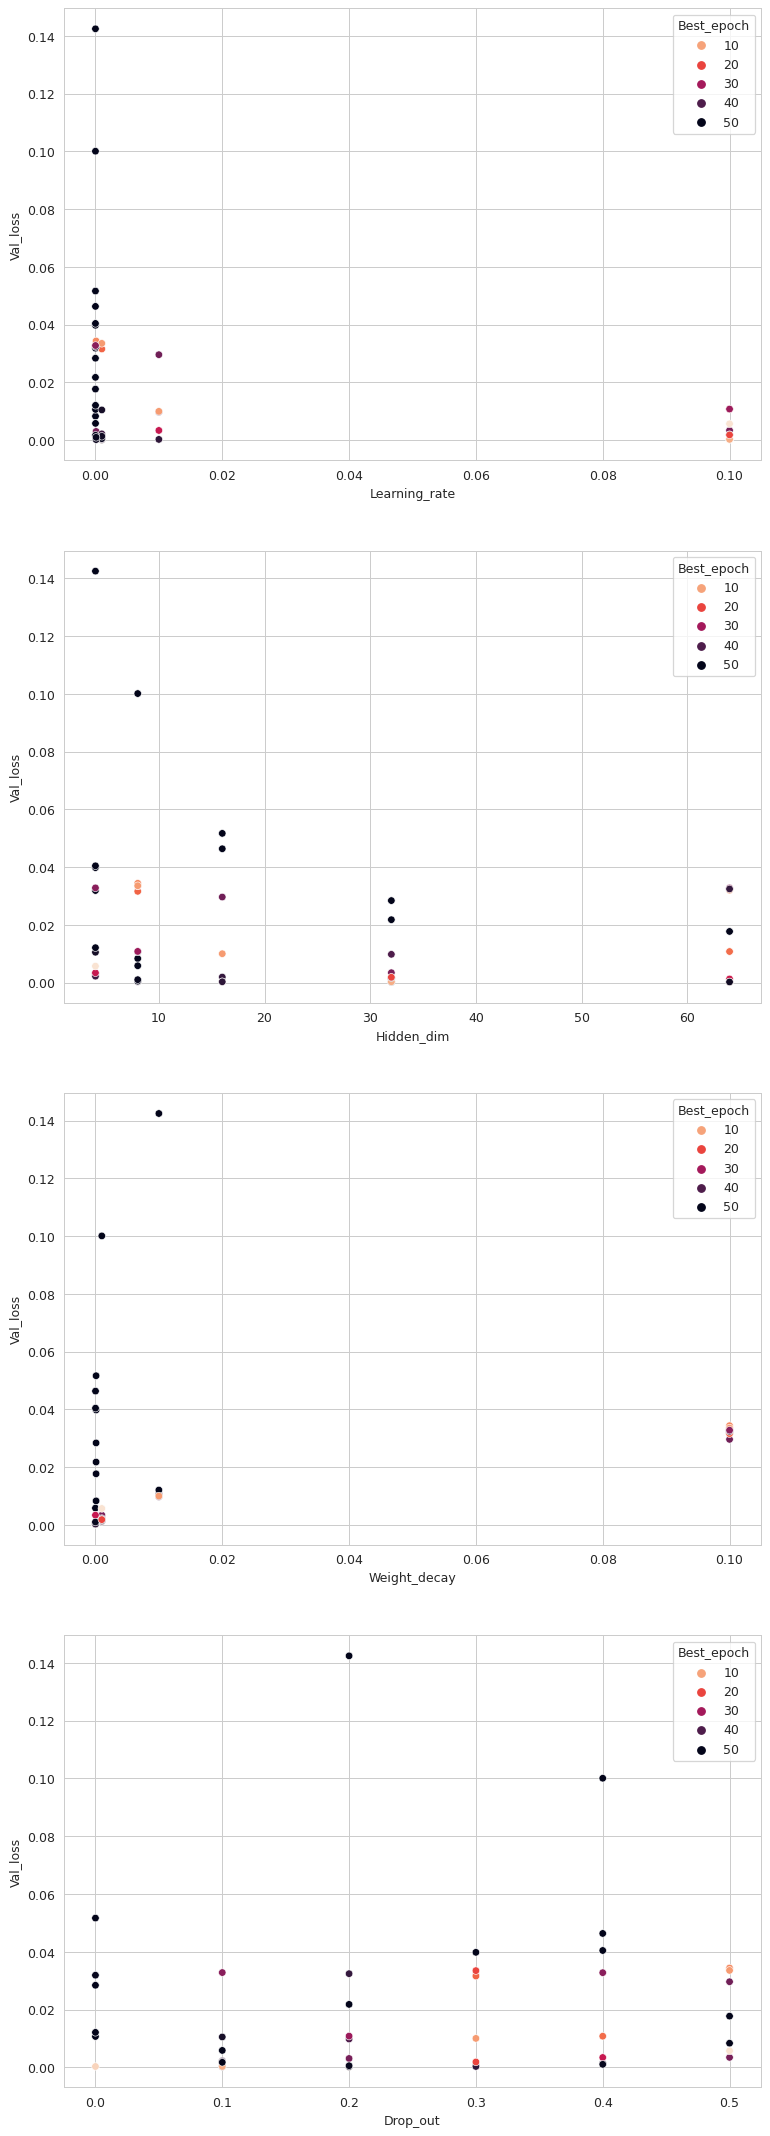

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 30), dpi=90)

for idx, feat in enumerate(['Learning_rate', 'Hidden_dim', 'Weight_decay', 'Drop_out']):
    sns.scatterplot(x=feat,
                    y='Val_loss',
                    data=para_result,
                    palette=sns.color_palette('rocket_r', as_cmap=True),
                    hue='Best_epoch',
                    ax=axes[idx])

### 7.1.5 Further Grid Search on Selected Parameter

In [ ]:
# Fixed parameters

INPUT_DIM = 14 # when entity embedding size = 3
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1
LEARNING_RATE = 1e-3
HIDDEN_DIM = 64
DROP_OUT = 0.2

In [ ]:
WEIGHT_DECAY = np.array([1e-5, 1e-6, 1e-7, 1e-8])

para_result = []

for wd in WEIGHT_DECAY:

    DisReg_MLP_tmp = DisReg_MLP_2Layer(
        INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

    optimiser = optim.Adam(
        DisReg_MLP_tmp.parameters(),
        lr=LEARNING_RATE, weight_decay=wd)

    criterion = torch.nn.MSELoss()

    train_model(DisReg_MLP_tmp,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val,
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False,
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)


    _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
    _, _, _ = load_model(
        SAVE_MODEL_NAME,
        DisReg_MLP_tmp,
        DisReg_MLP_tmp)

    print(
        'Weight decay: {}, Train loss: {:.7f}, Val loss: {:.7f}'.format(
            wd, best_loss_train, lowest_loss_val)
        )
    print('')

    para_result.append([wd, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result,
    columns=[
             'Weight_decay',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_1_5_para_result.m'
joblib.dump(para_result, file_path)

Training complete in: 0:02:13. Lowest validation loss occurred at epoch 31: 0.0002184
Weight decay: 1e-05, Train loss: 0.0003501, Val loss: 0.0002184

Training complete in: 0:02:14. Lowest validation loss occurred at epoch 41: 0.0001867
Weight decay: 1e-06, Train loss: 0.0003093, Val loss: 0.0001867

Training complete in: 0:02:13. Lowest validation loss occurred at epoch 19: 0.0001941
Weight decay: 1e-07, Train loss: 0.0003543, Val loss: 0.0001941

Training complete in: 0:02:14. Lowest validation loss occurred at epoch 14: 0.0001936
Weight decay: 1e-08, Train loss: 0.0003492, Val loss: 0.0001936



['/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_1_5_para_result.m']

### 7.1.6 Load Grid Search Result

We can see that weight decay of 1e-6 resulted in lowest validation loss.

Best parameters are:

* Learning Rate = 1e-3
* Hidden Dimension = 64
* Drop Out = 0.2
* Weight Decay = 1e-6

In [ ]:
file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_1_5_para_result.m'

para_result = joblib.load(file_path)

display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Weight_decay,Best_epoch,Train_loss,Val_loss
1,0.000001,41,0.000309,0.000187


## 7.2 Hyperparameter exploration with basic 3-layer MLP model with entity embedding size of 2

**Ensure entity embeddings with size 3 were loaded in Data Processing**

### 7.2.1 Define Model

In [ ]:
class DisReg_MLP_3Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, p):
        super(DisReg_MLP_3Layer, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, 1)

        self.act_1 = nn.ReLU()
        self.act_2 = nn.ReLU()
        self.act_3 = nn.Sigmoid()

        self.drop_1 = nn.Dropout(p)
        self.drop_2 = nn.Dropout(p)

    def forward(self, data):
        output = self.fc1(data)
        output = self.act_1(output)
        output = self.drop_1(output)

        output = self.fc2(output)
        output = self.act_2(output)
        output = self.drop_2(output)

        output = self.fc3(output)
        output = self.act_3(output)

        return output

In [ ]:
# Fixed parameters

INPUT_DIM = 14 # when entity embedding size = 3
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1

### 7.2.2 Random Search

In [ ]:
# Random Search

np.random.seed(32)

LEARNING_RATE = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
HIDDEN_DIM_1 = np.array([8, 16, 32, 64])
WEIGHT_DECAY = np.array([1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
DROP_OUT = np.array([0., 0.1, 0.2, 0.3, 0.4, 0.5])

para_result = []

N_TRIAL = 50

for trial in range(1, N_TRIAL+1):
    lr = np.random.choice(LEARNING_RATE)
    hd_1 = np.random.choice(HIDDEN_DIM_1)
    hd_2 = int(0.5*hd_1)
    wd = np.random.choice(WEIGHT_DECAY)
    dp = np.random.choice(DROP_OUT)

    DisReg_MLP_tmp = DisReg_MLP_3Layer(
        INPUT_DIM, hd_1, hd_2, dp).to(device)

    optimiser = optim.Adam(
        DisReg_MLP_tmp.parameters(),
        lr=lr, weight_decay=wd)

    criterion = torch.nn.MSELoss()

    print('Trial# ', trial)

    train_model(DisReg_MLP_tmp,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val,
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False,
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)


    _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
    _, _, _ = load_model(
        SAVE_MODEL_NAME,
        DisReg_MLP_tmp,
        DisReg_MLP_tmp)

    print(
        'Learning rate: {}, Hidden dim 1: {}, Hidden dim 2: {}, Weight decay: {},'\
        'Drop out: {}, Train loss: {:.7f}, Val loss: {:.7f}'.format(
            lr, hd_1, hd_2, wd, dp, best_loss_train, lowest_loss_val)
        )
    print('')

    para_result.append([lr, hd_1, hd_2, wd, dp, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result,
    columns=[
             'Learning_rate',
             'Hidden_dim_1',
             'Hidden_dim_2',
             'Weight_decay',
             'Drop_out',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_2_2_para_result.m'
joblib.dump(para_result, file_path)

Trial#  1
Training complete in: 0:02:30. Lowest validation loss occurred at epoch 50: 0.0002273
Learning rate: 0.0001, Hidden dim 1: 16, Hidden dim 2: 8, Weight decay: 1e-07,Drop out: 0.0, Train loss: 0.0002013, Val loss: 0.0002273

Trial#  2
Training complete in: 0:02:36. Lowest validation loss occurred at epoch 49: 0.00149
Learning rate: 0.0001, Hidden dim 1: 8, Hidden dim 2: 4, Weight decay: 0.0001,Drop out: 0.3, Train loss: 0.0048642, Val loss: 0.0014898

Trial#  3
Training complete in: 0:02:35. Lowest validation loss occurred at epoch 50: 0.04367
Learning rate: 1e-06, Hidden dim 1: 32, Hidden dim 2: 16, Weight decay: 0.0001,Drop out: 0.4, Train loss: 0.0533612, Val loss: 0.0436736

Trial#  4
Training complete in: 0:02:38. Lowest validation loss occurred at epoch 50: 0.0002082
Learning rate: 0.0001, Hidden dim 1: 16, Hidden dim 2: 8, Weight decay: 1e-06,Drop out: 0.1, Train loss: 0.0007784, Val loss: 0.0002082

Trial#  5
Training complete in: 0:02:37. Lowest validation loss occurre

['/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_2_2_para_result.m']

### 7.2.3 Load Random Search Result

We can extract the combination of hyperparameters with the lowest validation loss.

In [ ]:
file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_2_2_para_result.m'

para_result = joblib.load(file_path)

In [ ]:
display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Learning_rate,Hidden_dim_1,Hidden_dim_2,Weight_decay,Drop_out,Best_epoch,Train_loss,Val_loss
12,0.001,64,32,1.000000e-08,0.2,46,0.000531,0.000192


### 7.2.4 Plot Random Search Result

**Learning Rate**:

From the best parameters above, we can see the best learning rate is 0.001 which resulted in lowest validation loss at epoch 46. The speed of model convergence is acceptable.

Therefore, we will keep learning rate of 0.001 as our best learning rate.

**Hidden Dimension 1**:

From the best parameters above, we can see the best hidden dimension is 64.

From the figure below, it looks like the size of hidden dimension does not have much impact on the model convergence speed or validation loss.

Therefore, we will keep hidden dimension of 64 as our best hidden dimension.

**Hidden Dimension 2**:

From the best parameters above, we can see the best hidden dimension is 32. We have also set hidden himension 2 as half of hidden dimension 1 for simplicity during random search.

We may further explore the size of hidden dimension 2 with grid search.

**Weight Decay**:

From both the best parameters above and the figure below, we can see that the best weight decay is 1e-8, which is the lowest value in our search range. We can perform further grid search around this value to fine tune the weight decay.

**Drop Out**:

From the best parameters above, we can see the best drop out rate is 0.2.

From the figure below, we can see that low validation loss can be achieved regardless of the magnitude of the drop out rate.

Therefore, we will keep drop out rate of 0.2 as our best drop out rate.

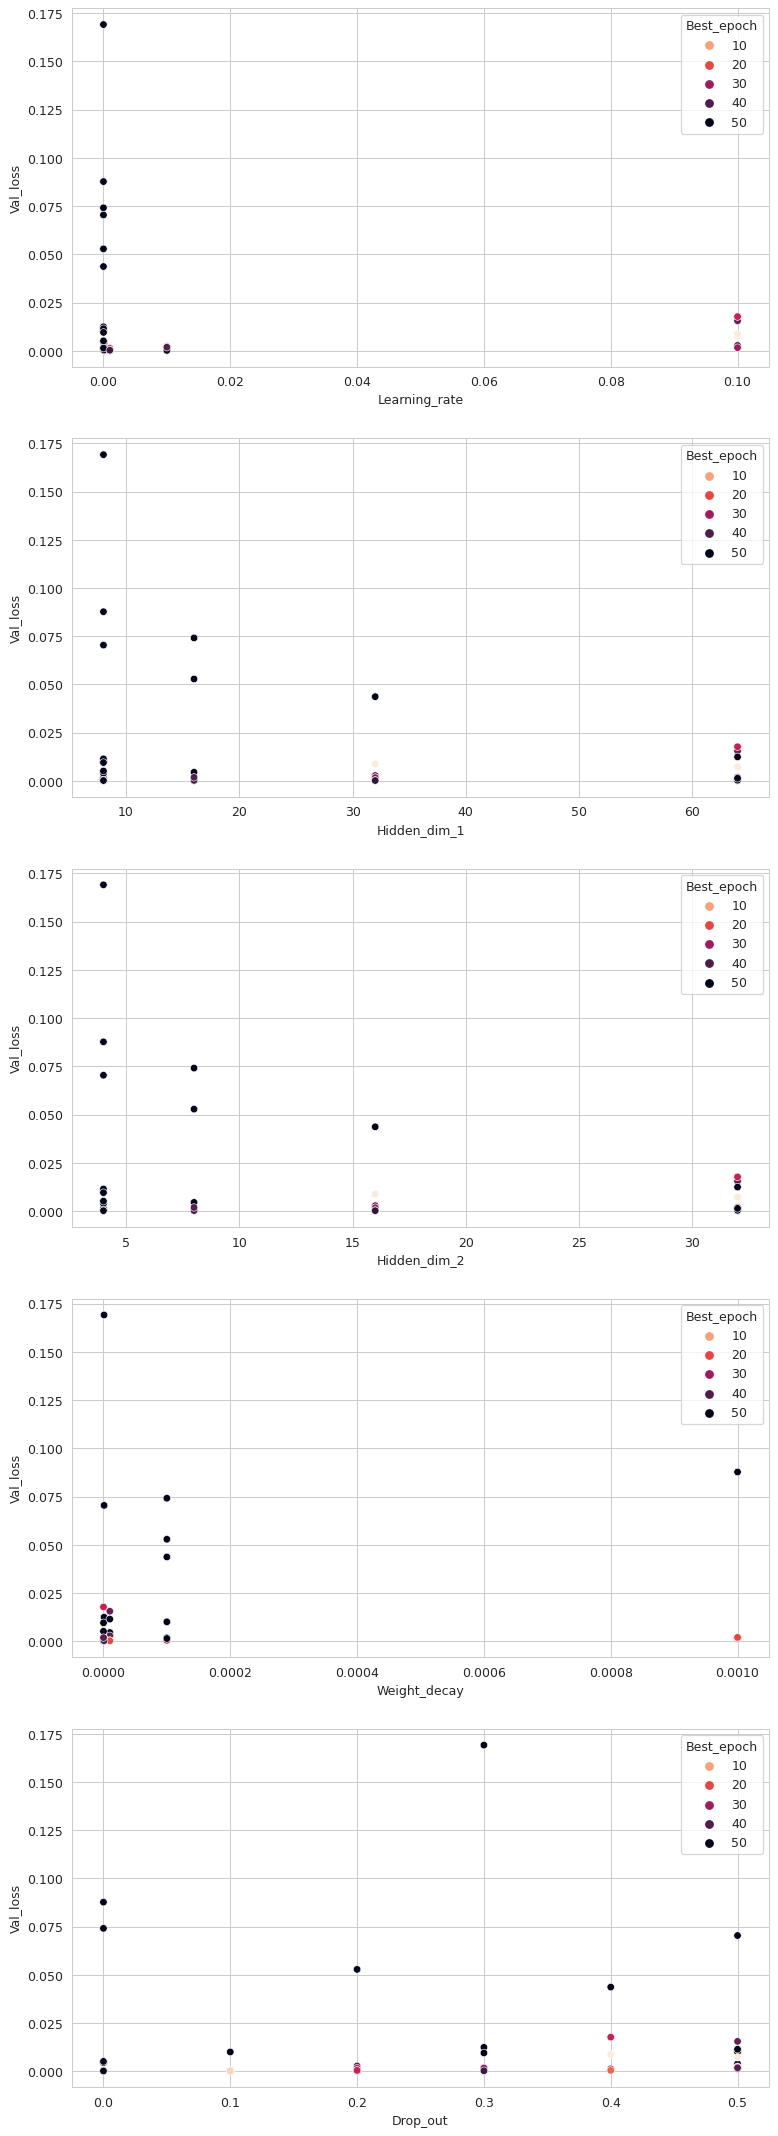

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 30), dpi=90)

for idx, feat in enumerate(['Learning_rate', 'Hidden_dim_1', 'Hidden_dim_2', 'Weight_decay', 'Drop_out']):
    sns.scatterplot(x=feat,
                    y='Val_loss',
                    data=para_result,
                    palette=sns.color_palette('rocket_r', as_cmap=True),
                    hue='Best_epoch',
                    ax=axes[idx])

### 7.2.5 Further Grid Search on Selected Parameters

In [ ]:
# Fixed parameters

INPUT_DIM = 14 # when entity embedding size = 3
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1
LEARNING_RATE = 1e-3
HIDDEN_DIM_1 = 64
DROP_OUT = 0.2

In [ ]:
WEIGHT_DECAY = np.array([1e-7, 1e-8, 1e-9, 1e-10])
HIDDEN_DIM_2 = np.array([8, 16, 32, 64])

para_result = []

for wd in WEIGHT_DECAY:
    for hd_2 in HIDDEN_DIM_2:

        DisReg_MLP_tmp = DisReg_MLP_3Layer(
            INPUT_DIM, HIDDEN_DIM_1, hd_2, DROP_OUT).to(device)

        optimiser = optim.Adam(
            DisReg_MLP_tmp.parameters(),
            lr=LEARNING_RATE, weight_decay=wd)

        criterion = torch.nn.MSELoss()

        train_model(DisReg_MLP_tmp,
                optimiser,
                criterion,
                N_EPOCHS,
                dl_train,
                dl_val,
                SHOW_PROGRESS_EPOCH,
                SAVE_MODEL_EPOCH,
                SAVE_MODEL_NAME,
                continue_train = False,
                previous_best_train_loss = 0,
                previous_lowest_val_loss = 0,
                best_model_state_dict = 0,
                previous_best_epoch = 0,
                previous_epochs = 0,
                previous_train_loss = 0,
                previous_val_loss = 0)


        _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
        _, _, _ = load_model(
            SAVE_MODEL_NAME,
            DisReg_MLP_tmp,
            DisReg_MLP_tmp)

        print(
            'Weight decay: {}, Hidden dim 2: {}, Train loss: {:.7f}, Val loss: {:.7f}'.format(
                wd, hd_2, best_loss_train, lowest_loss_val)
            )
        print('')

        para_result.append([wd, hd_2, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result,
    columns=[
             'Weight_decay',
             'hidden_dim_2',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_2_5_para_result.m'
joblib.dump(para_result, file_path)

Training complete in: 0:02:42. Lowest validation loss occurred at epoch 15: 0.0002149
Weight decay: 1e-07, Hidden dim 2: 8, Train loss: 0.0013271, Val loss: 0.0002149

Training complete in: 0:02:42. Lowest validation loss occurred at epoch 42: 0.0002045
Weight decay: 1e-07, Hidden dim 2: 16, Train loss: 0.0008152, Val loss: 0.0002045

Training complete in: 0:02:41. Lowest validation loss occurred at epoch 35: 0.0001979
Weight decay: 1e-07, Hidden dim 2: 32, Train loss: 0.0005013, Val loss: 0.0001979

Training complete in: 0:02:45. Lowest validation loss occurred at epoch 26: 0.0001993
Weight decay: 1e-07, Hidden dim 2: 64, Train loss: 0.0003969, Val loss: 0.0001993

Training complete in: 0:02:43. Lowest validation loss occurred at epoch 14: 0.0002271
Weight decay: 1e-08, Hidden dim 2: 8, Train loss: 0.0012747, Val loss: 0.0002271

Training complete in: 0:03:03. Lowest validation loss occurred at epoch 37: 0.0002016
Weight decay: 1e-08, Hidden dim 2: 16, Train loss: 0.0007671, Val loss:

['/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_2_5_para_result.m']

### 7.2.6 Load Grid Search Result

Best parameters are:

* Learning Rate = 1e-3
* Hidden Dimension 1 = 64
* Hidden Dimension 2 = 64
* Drop Out = 0.2
* Weight Decay = 1e-8

In [ ]:
file_path = '/content/drive/MyDrive/P3 Fitrec Dataset/Generated datsets fresh/Distance_Model/section_7_2_5_para_result.m'

para_result = joblib.load(file_path)

# show result with lowest validation loss
display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Weight_decay,hidden_dim_2,Best_epoch,Train_loss,Val_loss
7,1.000000e-08,64,35,0.000393,0.000195


## 7.3 2-layer MLP model Entity Embedding exploration

### 7.3.1 Define 2-layer MLP Model

In [ ]:
class DisReg_MLP_2Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, p):
        super(DisReg_MLP_2Layer, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, 1)

        self.act_1 = nn.ReLU()
        self.act_2 = nn.Sigmoid()

        self.drop_1 = nn.Dropout(p)

    def forward(self, data):

        output = self.fc1(data)
        output = self.act_1(output)
        output = self.drop_1(output)

        output = self.fc2(output)
        output = self.act_2(output)

        return output

### 7.3.2 Entity Embedding of size 3

* Ensure entity embedding of size 3 was loaded in Data Processing
* Train model with best parameters from section 7.1

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_2L_3'

INPUT_DIM = 14
HIDDEN_DIM = 64
DROP_OUT = 0.2

DisReg_MLP_2 = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_2.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_2,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val,
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False,
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

RuntimeError: ignored

In [ ]:
#Load Model

LOAD_MODEL_NAME = 'DisReg_MLP_2L_3'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6

INPUT_DIM = 14
HIDDEN_DIM = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

latest_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

FileNotFoundError: ignored

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

NameError: ignored

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.0001566
Average Test Set MSE at km: 0.02053


### 7.3.3 Entity Embedding of size 4

* Ensure entity embedding of size 4 was loaded in Data Processing
* Train model with best parameters from section 7.1

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_2L_4'

INPUT_DIM = 16
HIDDEN_DIM = 64
DROP_OUT = 0.2

DisReg_MLP_2 = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_2.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_2,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val,
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False,
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:03 | Train Loss: 0.0003315 | Val Loss: 0.0002327
Epoch: 20 Elapsed 0:00:03 | Train Loss: 0.0003038 | Val Loss: 0.0002144
Epoch: 30 Elapsed 0:00:03 | Train Loss: 0.0003084 | Val Loss: 0.0001997
Epoch: 40 Elapsed 0:00:03 | Train Loss: 0.0003085 | Val Loss: 0.0002052
Epoch: 50 Elapsed 0:00:02 | Train Loss: 0.0003085 | Val Loss: 0.0002301
Epoch: 60 Elapsed 0:00:03 | Train Loss: 0.0003033 | Val Loss: 0.0002193
Epoch: 70 Elapsed 0:00:03 | Train Loss: 0.0002991 | Val Loss: 0.0002249
Epoch: 80 Elapsed 0:00:03 | Train Loss: 0.0003067 | Val Loss: 0.0002269
Epoch: 90 Elapsed 0:00:02 | Train Loss: 0.0002993 | Val Loss: 0.0002032
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.000297 | Val Loss: 0.0002045
Epoch: 110 Elapsed 0:00:03 | Train Loss: 0.0002969 | Val Loss: 0.0001984
Epoch: 120 Elapsed 0:00:03 | Train Loss: 0.0002929 | Val Loss: 0.0002084
Epoch: 130 Elapsed 0:00:03 | Train Loss: 0.0002958 | Val Loss: 0.0002326
Epoch: 140 Elapsed 0:00:03 | Train Loss: 0.0003017 | Val Loss

In [ ]:
# Load Model

LOAD_MODEL_NAME = 'DisReg_MLP_2L_4'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6

INPUT_DIM = 16
HIDDEN_DIM = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

latest_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

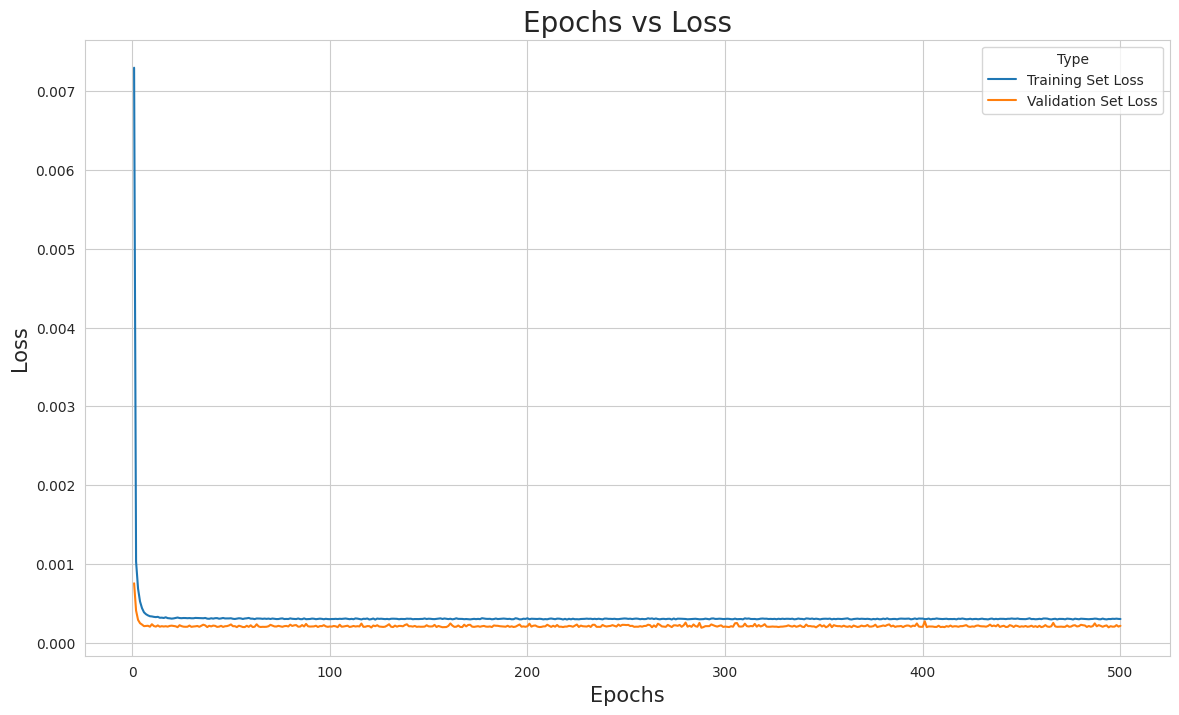

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.000165
Average Test Set MSE at km: 0.02163


### 7.3.4 Entity Embedding of size 9

* Ensure entity embedding of size 9 was loaded in Data Processing
* Train model with best parameters from section 7.1

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_2L_9'

INPUT_DIM = 26
HIDDEN_DIM = 64
DROP_OUT = 0.2

DisReg_MLP_2 = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_2.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_2,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val,
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False,
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:02 | Train Loss: 0.0003484 | Val Loss: 0.0002081
Epoch: 20 Elapsed 0:00:03 | Train Loss: 0.0003302 | Val Loss: 0.0001996
Epoch: 30 Elapsed 0:00:02 | Train Loss: 0.0003303 | Val Loss: 0.0002049
Epoch: 40 Elapsed 0:00:02 | Train Loss: 0.0003212 | Val Loss: 0.0002023
Epoch: 50 Elapsed 0:00:03 | Train Loss: 0.0003227 | Val Loss: 0.000213
Epoch: 60 Elapsed 0:00:02 | Train Loss: 0.0003183 | Val Loss: 0.0002076
Epoch: 70 Elapsed 0:00:02 | Train Loss: 0.0003131 | Val Loss: 0.0001981
Epoch: 80 Elapsed 0:00:03 | Train Loss: 0.0003169 | Val Loss: 0.0002107
Epoch: 90 Elapsed 0:00:02 | Train Loss: 0.0003094 | Val Loss: 0.0002003
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.0003148 | Val Loss: 0.0002059
Epoch: 110 Elapsed 0:00:02 | Train Loss: 0.0003104 | Val Loss: 0.0002007
Epoch: 120 Elapsed 0:00:02 | Train Loss: 0.0003047 | Val Loss: 0.0001998
Epoch: 130 Elapsed 0:00:03 | Train Loss: 0.0003108 | Val Loss: 0.0002025
Epoch: 140 Elapsed 0:00:02 | Train Loss: 0.0003108 | Val Loss

In [ ]:
# Load Model

LOAD_MODEL_NAME = 'DisReg_MLP_2L_9'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6

INPUT_DIM = 26
HIDDEN_DIM = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

latest_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

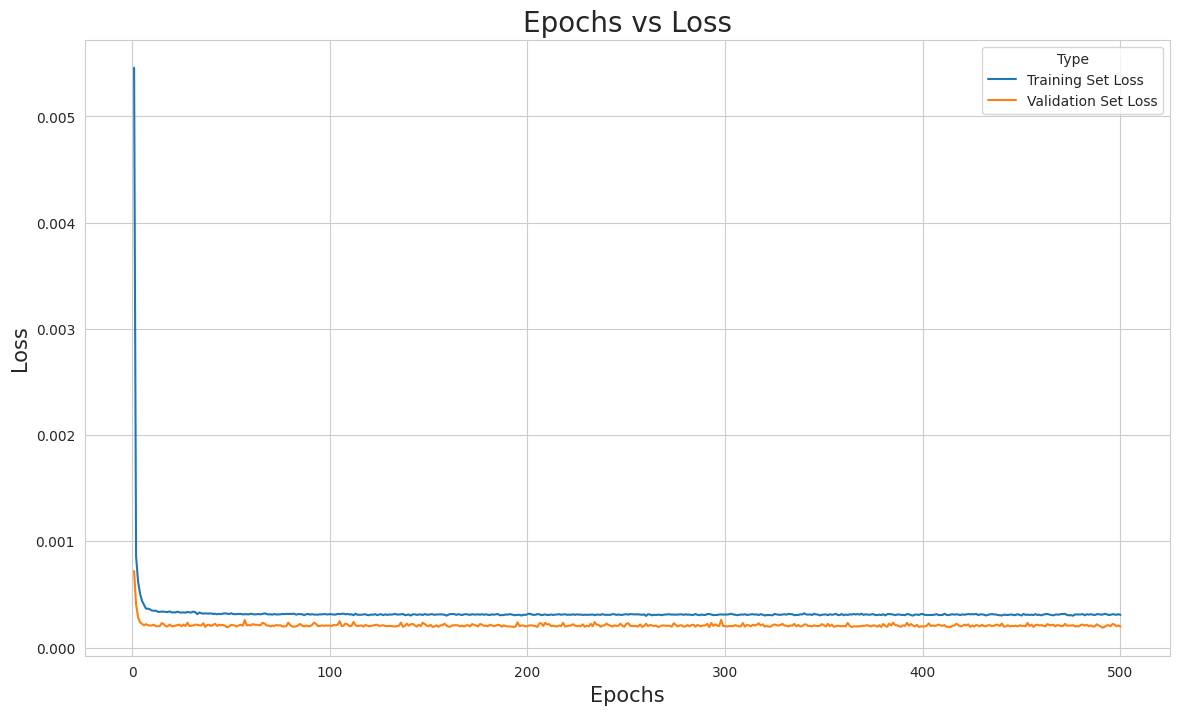

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.0001639
Average Test Set MSE at km: 0.02149


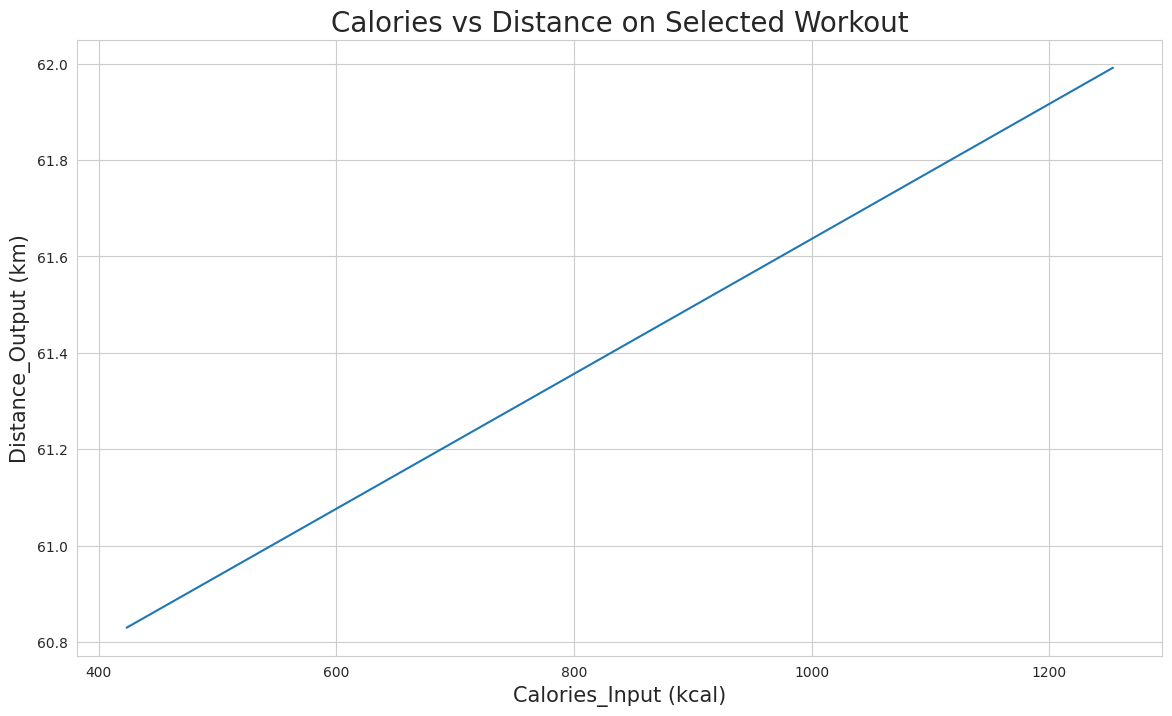

In [ ]:
# select a random workout route from test set and check the relationship between
# calories input and distance output


idx = 12271
data_origin = ds_test[idx][0]
label_origin = ds_test[idx][1]
# original calorie input
cal_origin = data_origin[0]

# get calories from 0.5*original calories to 1.5*original calories
calories = np.arange(cal_origin*0.5, cal_origin*1.5, cal_origin/50)

data_new = []
pred = []

# prepare model input data for the calories range
for cal in calories:
    data_new.append(np.hstack((np.array(cal), data_origin[1:])))

# get model output for the calories range
best_model.eval()
with torch.no_grad():
    for data in data_new:
        pred.append(best_model(torch.Tensor(data).to(device)).item())

# convert calories and distance to original scale
calories = scaler_dic['calories'].inverse_transform(
    np.array(calories).reshape(-1, 1)).flatten()
pred = scaler_dic['workout_distance'].inverse_transform(
    np.array(pred).reshape(-1, 1)).flatten()


# convert to df and plot with seaborn
pred_df = pd.DataFrame(zip(calories, pred), columns=[
    'Calories_Input', 'Distance_Output'])

plt.figure(figsize=(14, 8))
g = sns.lineplot(
    x='Calories_Input',
    y='Distance_Output',
    data=pred_df)
g.set_title('Calories vs Distance on Selected Workout', fontsize=20)
g.set_xlabel('Calories_Input (kcal)', fontsize=15)
g.set_ylabel('Distance_Output (km)', fontsize=15)

plt.show()

# **Entity Embedding of size 17**

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_2L_17'

INPUT_DIM = 42
HIDDEN_DIM = 64
DROP_OUT = 0.2

DisReg_MLP_2 = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_2.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_2,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val,
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False,
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:03 | Train Loss: 0.0003482 | Val Loss: 0.000239
Epoch: 20 Elapsed 0:00:04 | Train Loss: 0.0003252 | Val Loss: 0.0002196
Epoch: 30 Elapsed 0:00:04 | Train Loss: 0.0003166 | Val Loss: 0.0002009
Epoch: 40 Elapsed 0:00:03 | Train Loss: 0.000314 | Val Loss: 0.0002013
Epoch: 50 Elapsed 0:00:07 | Train Loss: 0.0003061 | Val Loss: 0.0001989
Epoch: 60 Elapsed 0:00:03 | Train Loss: 0.0003148 | Val Loss: 0.0002122
Epoch: 70 Elapsed 0:00:03 | Train Loss: 0.0003085 | Val Loss: 0.0002057
Epoch: 80 Elapsed 0:00:09 | Train Loss: 0.000307 | Val Loss: 0.0002009
Epoch: 90 Elapsed 0:00:03 | Train Loss: 0.0003036 | Val Loss: 0.0002082
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.0003039 | Val Loss: 0.0002099
Epoch: 110 Elapsed 0:00:04 | Train Loss: 0.0003039 | Val Loss: 0.0002043
Epoch: 120 Elapsed 0:00:03 | Train Loss: 0.0003082 | Val Loss: 0.0002375
Epoch: 130 Elapsed 0:00:02 | Train Loss: 0.0003077 | Val Loss: 0.0001975
Epoch: 140 Elapsed 0:00:03 | Train Loss: 0.0003094 | Val Loss: 

In [ ]:
# Load Model

LOAD_MODEL_NAME = 'DisReg_MLP_2L_17'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6

INPUT_DIM = 42
HIDDEN_DIM = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

latest_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

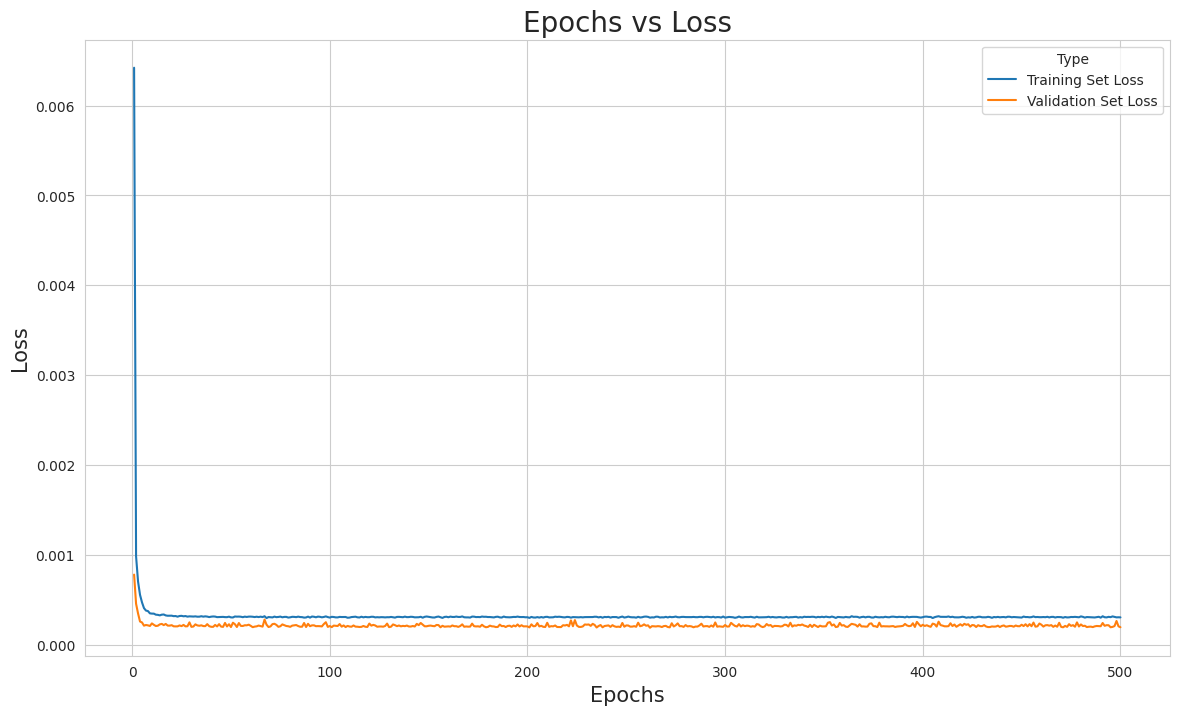

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.0001688
Average Test Set MSE at km: 0.02213


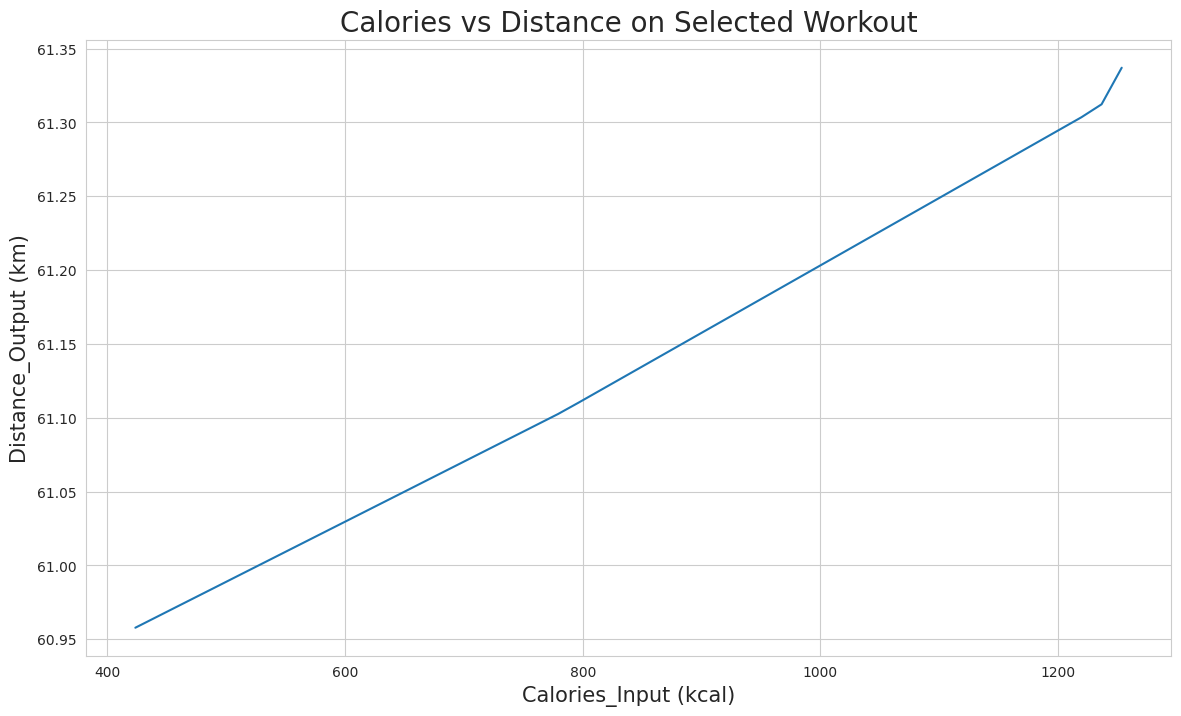

In [ ]:
# select a random workout route from test set and check the relationship between
# calories input and distance output


idx = 12271
data_origin = ds_test[idx][0]
label_origin = ds_test[idx][1]
# original calorie input
cal_origin = data_origin[0]

# get calories from 0.5*original calories to 1.5*original calories
calories = np.arange(cal_origin*0.5, cal_origin*1.5, cal_origin/50)

data_new = []
pred = []

# prepare model input data for the calories range
for cal in calories:
    data_new.append(np.hstack((np.array(cal), data_origin[1:])))

# get model output for the calories range
best_model.eval()
with torch.no_grad():
    for data in data_new:
        pred.append(best_model(torch.Tensor(data).to(device)).item())

# convert calories and distance to original scale
calories = scaler_dic['calories'].inverse_transform(
    np.array(calories).reshape(-1, 1)).flatten()
pred = scaler_dic['workout_distance'].inverse_transform(
    np.array(pred).reshape(-1, 1)).flatten()


# convert to df and plot with seaborn
pred_df = pd.DataFrame(zip(calories, pred), columns=[
    'Calories_Input', 'Distance_Output'])

plt.figure(figsize=(14, 8))
g = sns.lineplot(
    x='Calories_Input',
    y='Distance_Output',
    data=pred_df)
g.set_title('Calories vs Distance on Selected Workout', fontsize=20)
g.set_xlabel('Calories_Input (kcal)', fontsize=15)
g.set_ylabel('Distance_Output (km)', fontsize=15)

plt.show()

## 7.4 3-layer MLP model Entity Embedding Exploration

### 7.4.1 Define 3-layer MLP Model

In [ ]:
class DisReg_MLP_3Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, p):
        super(DisReg_MLP_3Layer, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, 1)

        self.act_1 = nn.ReLU()
        self.act_2 = nn.ReLU()
        self.act_3 = nn.Sigmoid()

        self.drop_1 = nn.Dropout(p)
        self.drop_2 = nn.Dropout(p)

    def forward(self, data):
        output = self.fc1(data)
        output = self.act_1(output)
        output = self.drop_1(output)

        output = self.fc2(output)
        output = self.act_2(output)
        output = self.drop_2(output)

        output = self.fc3(output)
        output = self.act_3(output)

        return output

### 7.4.2 Entity Embedding of size 3

* Ensure entity embedding of size 3 was loaded in Data Processing
* Train model with best parameters from section 7.3

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_3L_3'

INPUT_DIM = 14
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

DisReg_MLP_3 = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_3.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_3,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val,
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False,
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:03 | Train Loss: 0.0004242 | Val Loss: 0.0002041
Epoch: 20 Elapsed 0:00:03 | Train Loss: 0.0003965 | Val Loss: 0.000203
Epoch: 30 Elapsed 0:00:03 | Train Loss: 0.000398 | Val Loss: 0.0002025
Epoch: 40 Elapsed 0:00:03 | Train Loss: 0.0003872 | Val Loss: 0.0002111
Epoch: 50 Elapsed 0:00:03 | Train Loss: 0.0003795 | Val Loss: 0.0002206
Epoch: 60 Elapsed 0:00:03 | Train Loss: 0.0003747 | Val Loss: 0.0001984
Epoch: 70 Elapsed 0:00:03 | Train Loss: 0.0003708 | Val Loss: 0.000206
Epoch: 80 Elapsed 0:00:03 | Train Loss: 0.0003739 | Val Loss: 0.0002188
Epoch: 90 Elapsed 0:00:03 | Train Loss: 0.0003645 | Val Loss: 0.0002029
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.0003702 | Val Loss: 0.0002145
Epoch: 110 Elapsed 0:00:03 | Train Loss: 0.0003757 | Val Loss: 0.0002038
Epoch: 120 Elapsed 0:00:03 | Train Loss: 0.000371 | Val Loss: 0.0002047
Epoch: 130 Elapsed 0:00:03 | Train Loss: 0.0003677 | Val Loss: 0.0002075
Epoch: 140 Elapsed 0:00:03 | Train Loss: 0.0003667 | Val Loss: 0

In [ ]:
LOAD_MODEL_NAME = 'DisReg_MLP_3L_3'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8

INPUT_DIM = 14
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

latest_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

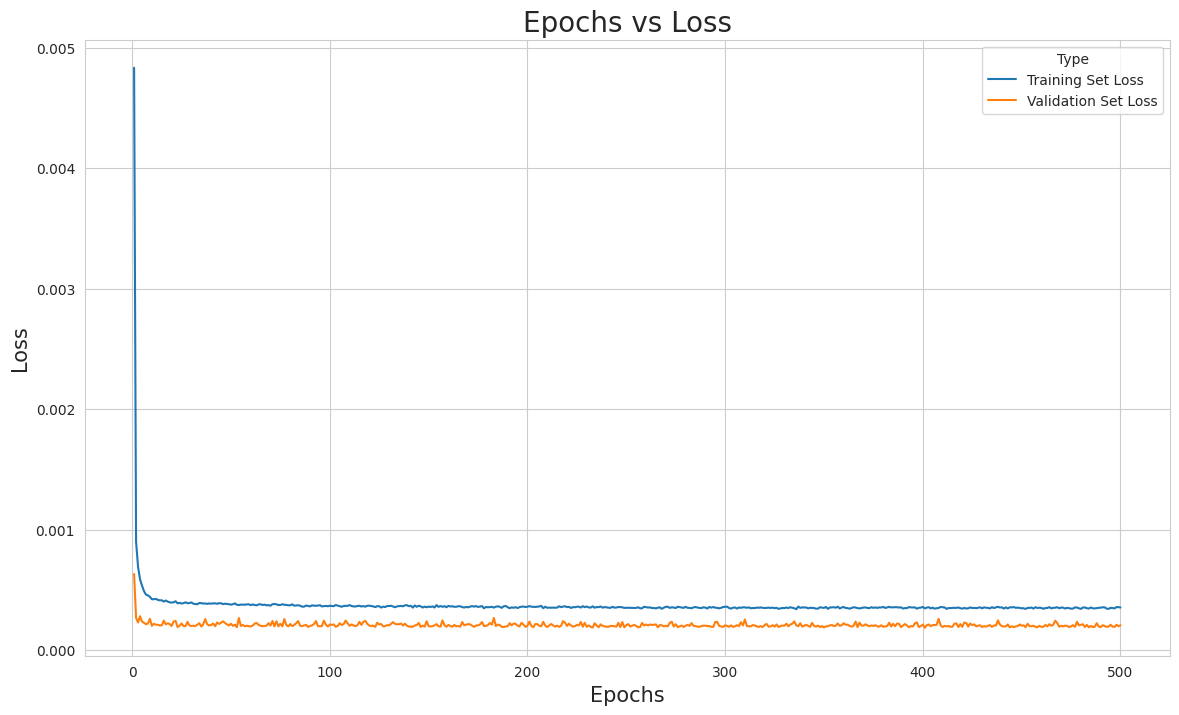

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.000153
Average Test Set MSE at km: 0.02006


### 7.4.3 Entity Embedding of size 4

* Ensure entity embedding of size 4 was loaded in Data Processing
* Train model with best parameters from section 7.3

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_3L_4'

INPUT_DIM = 16
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

DisReg_MLP_3 = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_3.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_3,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val,
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False,
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:03 | Train Loss: 0.0004365 | Val Loss: 0.0002053
Epoch: 20 Elapsed 0:00:03 | Train Loss: 0.0004022 | Val Loss: 0.0002099
Epoch: 30 Elapsed 0:00:03 | Train Loss: 0.0004022 | Val Loss: 0.0002462
Epoch: 40 Elapsed 0:00:03 | Train Loss: 0.000391 | Val Loss: 0.0002204
Epoch: 50 Elapsed 0:00:03 | Train Loss: 0.0003888 | Val Loss: 0.0001982
Epoch: 60 Elapsed 0:00:03 | Train Loss: 0.0003896 | Val Loss: 0.0002797
Epoch: 70 Elapsed 0:00:04 | Train Loss: 0.0003836 | Val Loss: 0.0002026
Epoch: 80 Elapsed 0:00:04 | Train Loss: 0.000388 | Val Loss: 0.0002159
Epoch: 90 Elapsed 0:00:04 | Train Loss: 0.0003732 | Val Loss: 0.0002551
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.0003857 | Val Loss: 0.0002192
Epoch: 110 Elapsed 0:00:03 | Train Loss: 0.0003801 | Val Loss: 0.0002067
Epoch: 120 Elapsed 0:00:03 | Train Loss: 0.000377 | Val Loss: 0.0002115
Epoch: 130 Elapsed 0:00:03 | Train Loss: 0.0003737 | Val Loss: 0.0002097
Epoch: 140 Elapsed 0:00:03 | Train Loss: 0.0003798 | Val Loss: 

In [ ]:
LOAD_MODEL_NAME = 'DisReg_MLP_3L_4'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8

INPUT_DIM = 16
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

latest_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

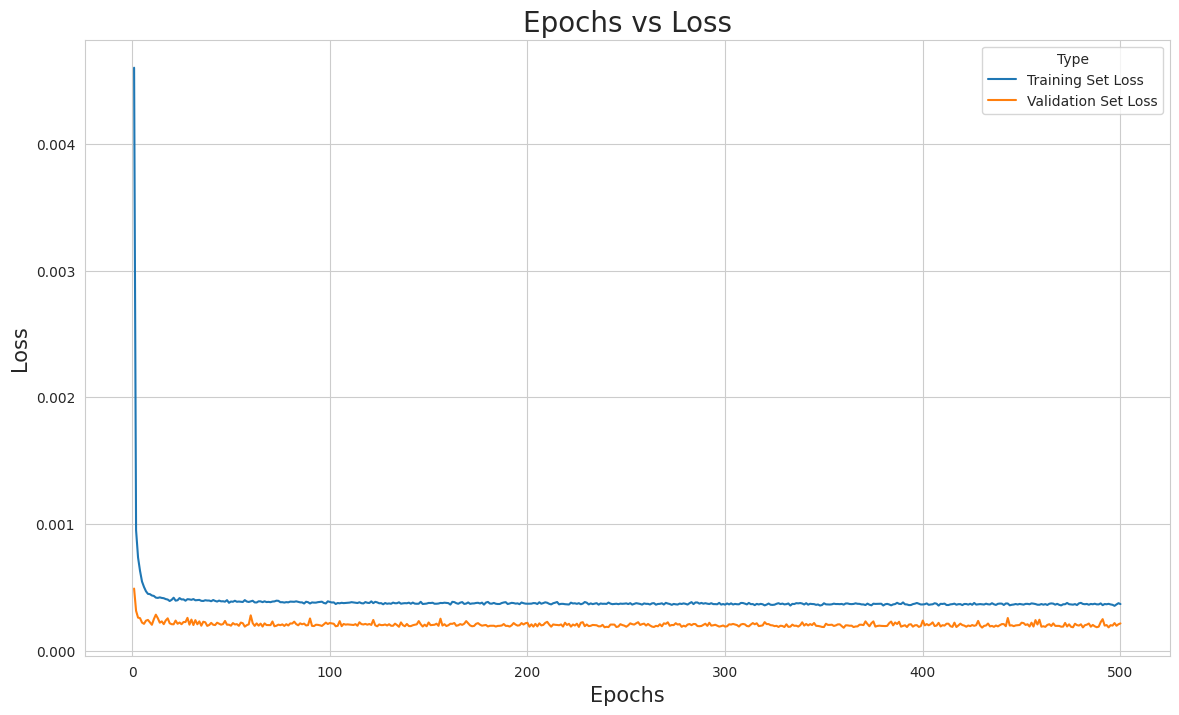

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.0001605
Average Test Set MSE at km: 0.02105


### 7.4.4 Entity Embedding of size 9

* Ensure entity embedding of size 9 was loaded in Data Processing
* Train model with best parameters from section 7.3

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_3L_9'

INPUT_DIM = 26
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

DisReg_MLP_3 = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_3.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_3,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val,
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False,
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:04 | Train Loss: 0.0004305 | Val Loss: 0.0002237
Epoch: 20 Elapsed 0:00:04 | Train Loss: 0.0004002 | Val Loss: 0.0002011
Epoch: 30 Elapsed 0:00:03 | Train Loss: 0.0003903 | Val Loss: 0.0002141
Epoch: 40 Elapsed 0:00:03 | Train Loss: 0.0003813 | Val Loss: 0.0002277
Epoch: 50 Elapsed 0:00:03 | Train Loss: 0.0003711 | Val Loss: 0.0002453
Epoch: 60 Elapsed 0:00:03 | Train Loss: 0.0003753 | Val Loss: 0.0002317
Epoch: 70 Elapsed 0:00:03 | Train Loss: 0.0003741 | Val Loss: 0.0002151
Epoch: 80 Elapsed 0:00:03 | Train Loss: 0.0003715 | Val Loss: 0.0002408
Epoch: 90 Elapsed 0:00:03 | Train Loss: 0.0003763 | Val Loss: 0.00021
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.000361 | Val Loss: 0.0002399
Epoch: 110 Elapsed 0:00:03 | Train Loss: 0.0003746 | Val Loss: 0.0001971
Epoch: 120 Elapsed 0:00:03 | Train Loss: 0.0003658 | Val Loss: 0.0001943
Epoch: 130 Elapsed 0:00:03 | Train Loss: 0.0003646 | Val Loss: 0.0001926
Epoch: 140 Elapsed 0:00:04 | Train Loss: 0.000363 | Val Loss: 0

In [ ]:
LOAD_MODEL_NAME = 'DisReg_MLP_3L_9'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8

INPUT_DIM = 26
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

latest_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

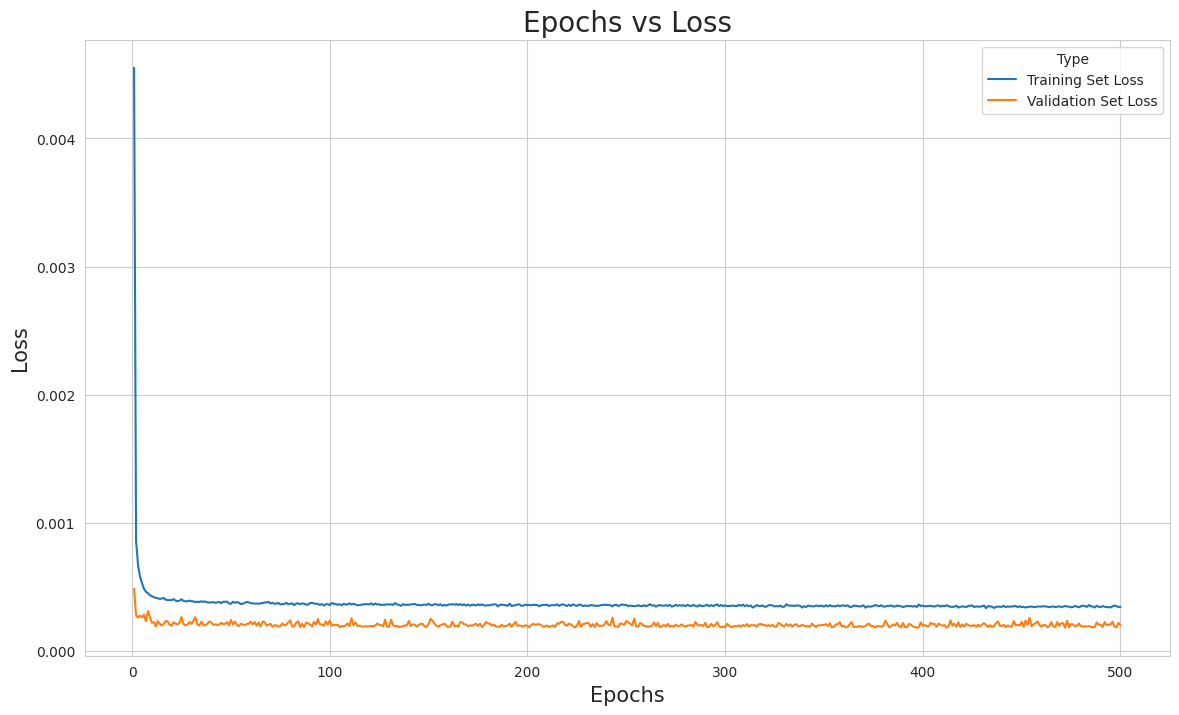

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.0001452
Average Test Set MSE at km: 0.01904


# **Embedding of size 17**

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_3L_17'

INPUT_DIM = 42
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

DisReg_MLP_3 = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_3.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_3,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val,
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False,
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:03 | Train Loss: 0.0004617 | Val Loss: 0.0002365
Epoch: 20 Elapsed 0:00:03 | Train Loss: 0.0004092 | Val Loss: 0.000227
Epoch: 30 Elapsed 0:00:04 | Train Loss: 0.0003922 | Val Loss: 0.0002246
Epoch: 40 Elapsed 0:00:04 | Train Loss: 0.0003919 | Val Loss: 0.0002104
Epoch: 50 Elapsed 0:00:04 | Train Loss: 0.0003825 | Val Loss: 0.0002219
Epoch: 60 Elapsed 0:00:03 | Train Loss: 0.0003721 | Val Loss: 0.0001997
Epoch: 70 Elapsed 0:00:03 | Train Loss: 0.0003812 | Val Loss: 0.0002172
Epoch: 80 Elapsed 0:00:03 | Train Loss: 0.0003717 | Val Loss: 0.0002221
Epoch: 90 Elapsed 0:00:03 | Train Loss: 0.0003656 | Val Loss: 0.000219
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.0003694 | Val Loss: 0.0002041
Epoch: 110 Elapsed 0:00:03 | Train Loss: 0.000361 | Val Loss: 0.0002015
Epoch: 120 Elapsed 0:00:03 | Train Loss: 0.0003594 | Val Loss: 0.0002013
Epoch: 130 Elapsed 0:00:04 | Train Loss: 0.0003606 | Val Loss: 0.0002199
Epoch: 140 Elapsed 0:00:04 | Train Loss: 0.0003653 | Val Loss: 

In [ ]:
LOAD_MODEL_NAME = 'DisReg_MLP_3L_17'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-8

INPUT_DIM = 42
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

latest_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

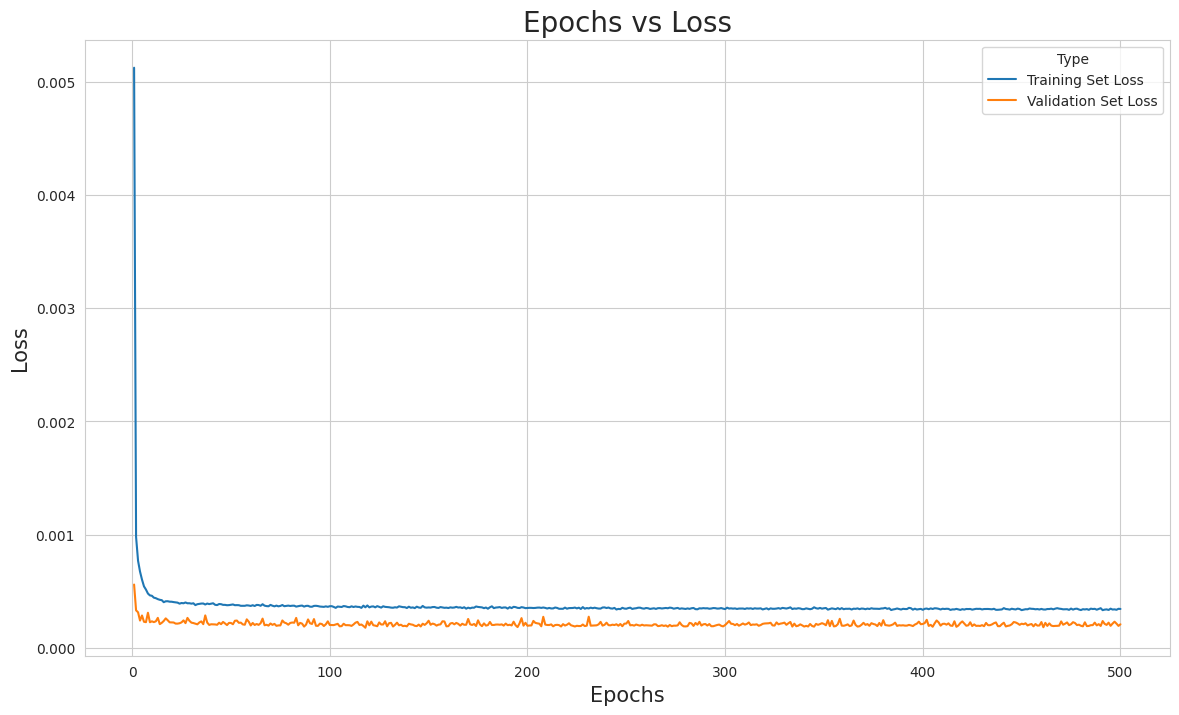

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.000156
Average Test Set MSE at km: 0.02045
